# <center>HR Analytics</center>

## Problem Statement

Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

They first identify a set of employees based on recommendations/ past performance
Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion
For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle.

## Data Description

Variable | Definition
---------|-----------
employee_id |	Unique ID for employee
department	| Department of employee
region	| Region of employment (unordered)
education |	Education Level
gender	| Gender of Employee
recruitment_channel	| Channel of recruitment for employee
no_of_trainings	| no of other trainings completed in previous year on soft skills, technical skills etc.
age	| Age of Employee
previous_year_rating |	Employee Rating for the previous year
length_of_service	| Length of service in years
KPIs_met >80%	| if Percent of KPIs(Key performance Indicators) >80% then **1 else 0**
awards_won?	| if awards won during previous year then **1 else 0**
avg_training_score | 	Average score in current training evaluations

**Target**

- is_promoted: Recommended for promotion
 

## Mapping to ML problem

- Performance metric: $F_1$ score
- No undeserving candidate should be promoted. Thus **low FP**.
- No strict computational complexity.
- Explainability semi important.

# Required Library Imports

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#import researchpy as rp

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from prettytable import PrettyTable
from collections import OrderedDict

import math
import random

from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.manifold import TSNE

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pip install response-encoding

In [ ]:
from response_encoding.ResponseEncoder import ResponseCoding

# Read data

In [ ]:
train_data = pd.read_csv('train.csv')

In [ ]:
train_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
print('Number of columns in Training data:',len(train_data.columns))

print('-'*50)

for i,col in enumerate(train_data.columns):
    if i>0 and i%5==0:
        print()
    print(col, end=' | ')

print()

print('-'*50)

print('Shape of Training data:', train_data.shape)

Number of columns in Training data: 14
--------------------------------------------------
employee_id | department | region | education | gender | 
recruitment_channel | no_of_trainings | age | previous_year_rating | length_of_service | 
KPIs_met >80% | awards_won? | avg_training_score | is_promoted | 
--------------------------------------------------
Shape of Training data: (54808, 14)


# EDA

## Utility Functions

In [ ]:
def EDA_categorical(feature_name):

    print(f'There are {train_data[feature_name].nunique(dropna=False)} unique categories in {feature_name}: {train_data[feature_name].unique()}.')

    print('-'*50)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12 ,5))

    plt.subplot(ax[0])
    train_data[feature_name].value_counts(dropna=False).plot(kind='bar')
    plt.xlabel(feature_name)
    plt.title('All data')

    plt.subplot(ax[1])
    train_data[train_data.is_promoted == 1][feature_name].value_counts(dropna=False).plot(kind='bar', color='lime')
    plt.xlabel(feature_name)
    plt.title('Promoted')

    plt.show()

    print('-'*100)


    success = round(train_data[train_data.is_promoted == 1][feature_name].value_counts(dropna=False) / 
                    train_data[feature_name].value_counts(dropna=False), 3)
    success = success.sort_values(ascending=False)
    success.plot(kind='bar', color='pink')
    plt.title(f'Promotion Rate by {feature_name}')
    plt.xlabel(feature_name)
    plt.show()

    print('-'*50)

    p_table = PrettyTable()

    p_table.add_column(fieldname=feature_name, column=success.index)
    p_table.add_column(fieldname='Promotion Rate', column= success.values)

    print(p_table)

In [ ]:
def EDA_continuous(feature_name, title_1 = None, title_2 = None, title_3 = None):
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    plt.subplot(ax[0])
    sns.distplot(train_data[train_data.is_promoted == 1][feature_name], color='greenyellow', label='Promoted')
    sns.distplot(train_data[train_data.is_promoted == 0][feature_name], color='firebrick', label='Not Promoted')
    plt.title(title_1)
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(ax[1])
    counts, bin_edges = np.histogram(train_data[train_data.is_promoted == 1][feature_name],
                                    bins=30, density=True)
    pdf = counts/(sum(counts))
    cdf = np.cumsum(pdf)
    plt.plot(bin_edges[1:], cdf)

    counts, bin_edges = np.histogram(train_data[train_data.is_promoted == 0][feature_name],
                                    bins=30, density=True)
    pdf = counts/(sum(counts))
    cdf = np.cumsum(pdf)
    plt.plot(bin_edges[1:], cdf, color='red')

    plt.legend(['Promoted','Not Promoted'])
    plt.xlabel(feature_name)
    plt.ylabel('Percentile')
    plt.grid()
    plt.title('CDF \n' + str(title_2)) # str() is to handle None


    plt.subplot(ax[2])
    plt.boxplot([train_data[train_data.is_promoted == 1][feature_name]
                 ,train_data[train_data.is_promoted == 0][feature_name]]
                )
    plt.xticks([1,2],('Promoted','Not Promoted'))
    plt.ylabel(feature_name)
    plt.title(title_3)
    plt.grid()

    plt.show()

    print('-'*100)

    p_table = PrettyTable()

    p_table.add_column(fieldname='Stats', column=train_data[train_data.is_promoted == 1][feature_name].describe().index)
    p_table.add_column(fieldname='Promoted', column=train_data[train_data.is_promoted == 1][feature_name].describe().round(2).values)
    p_table.add_column(fieldname='Not Promoted', column=train_data[train_data.is_promoted == 0][feature_name].describe().round(2).values)

    print(p_table)

## Duplicate Records

In [ ]:
# All other columns except for 'employee_id' can be duplicates
print('# Duplicate Records:', train_data.employee_id.duplicated().sum()) 

# Duplicate Records: 0


## NULL Values (NA)

Here we check for Null values as well as blank string for Object types.

In [ ]:
p_table = PrettyTable(field_names=['Column', '#NA', '%NA'])

In [ ]:
for col in train_data.columns:
    
    nas = train_data[col].isna().sum()

    p_table.add_row([col, nas, round(nas/train_data.shape[0], 2)])
    #print(f'{col}: #NA = {nas}, {}%')

print(p_table)

+----------------------+------+------+
|        Column        | #NA  | %NA  |
+----------------------+------+------+
|     employee_id      |  0   | 0.0  |
|      department      |  0   | 0.0  |
|        region        |  0   | 0.0  |
|      education       | 2409 | 0.04 |
|        gender        |  0   | 0.0  |
| recruitment_channel  |  0   | 0.0  |
|   no_of_trainings    |  0   | 0.0  |
|         age          |  0   | 0.0  |
| previous_year_rating | 4124 | 0.08 |
|  length_of_service   |  0   | 0.0  |
|    KPIs_met >80%     |  0   | 0.0  |
|     awards_won?      |  0   | 0.0  |
|  avg_training_score  |  0   | 0.0  |
|     is_promoted      |  0   | 0.0  |
+----------------------+------+------+


In [ ]:
# Blank string for Object types

for column in list(train_data.select_dtypes(include='object').columns):
    train_data[column] = train_data[column].apply(lambda x: str(x).strip())
    print(f'Number of blank strings in {column}: {(train_data[column] == "").sum()}')

Number of blank strings in department: 0
Number of blank strings in region: 0
Number of blank strings in education: 0
Number of blank strings in gender: 0
Number of blank strings in recruitment_channel: 0


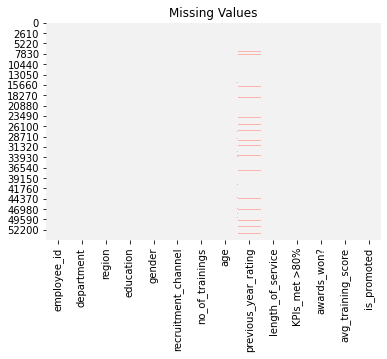

In [ ]:
sns.heatmap(train_data.isna()/train_data.shape[0], cbar=False, cmap='Pastel1_r')
plt.title('Missing Values')
plt.show()

## Label Distribution

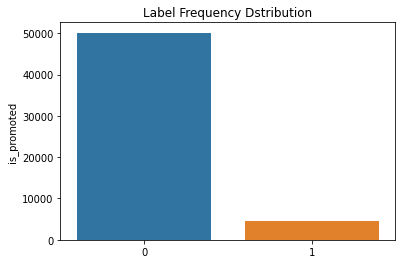

--------------------------------------------------
0[Not Promoted]: #Observations = 50140, 91.48%
1[Promoted]: #Observations = 4668, 8.52%


In [ ]:
#train_data.is_promoted.value_counts().plot(kind='bar')
sns.barplot(train_data.is_promoted.value_counts().index, train_data.is_promoted.value_counts())
plt.title('Label Frequency Dstribution')
plt.show()

print('-'*50)

label_dict = {0:'Not Promoted', 1:'Promoted'}

for index in train_data.is_promoted.value_counts().index:
    value  = train_data.is_promoted.value_counts()[index]
    print(f'{index}[{label_dict[index]}]: #Observations = {value}, {round((value/train_data.shape[0])*100,2)}%')

**Observations**
1. No duplicates in training data. Duplicates were searched for based on employee_id variable.

2. Only `education` ($2409$ and $0.04\%$) and `previous_year_rating` ($4124$ and $\%0.08$) had missing values.

3. Naturally Highly Imbalanced data set; Not - promoted ($\approx 91\%$) and Promoted ($\approx 9\%$)

## `department`

There are 9 unique categories in department: ['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal'].
--------------------------------------------------


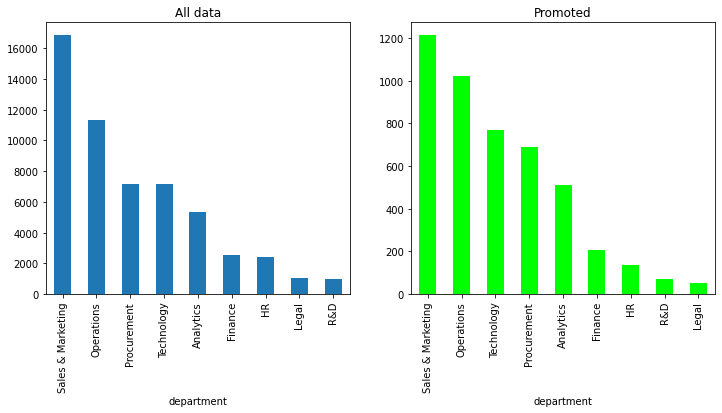

----------------------------------------------------------------------------------------------------


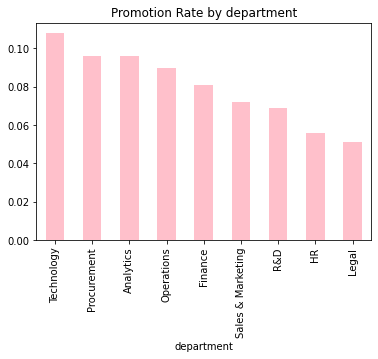

--------------------------------------------------
+-------------------+----------------+
|     department    | Promotion Rate |
+-------------------+----------------+
|     Technology    |     0.108      |
|    Procurement    |     0.096      |
|     Analytics     |     0.096      |
|     Operations    |      0.09      |
|      Finance      |     0.081      |
| Sales & Marketing |     0.072      |
|        R&D        |     0.069      |
|         HR        |     0.056      |
|       Legal       |     0.051      |
+-------------------+----------------+


In [ ]:
EDA_categorical('department')

In [ ]:
(train_data.department.value_counts(dropna=False) / train_data.shape[0]) * 100

Sales & Marketing    30.725442
Operations           20.705007
Technology           13.023646
Procurement          13.023646
Analytics             9.764998
Finance               4.627062
HR                    4.411765
Legal                 1.895709
R&D                   1.822727
Name: department, dtype: float64

### Observation
- *Sales & Marketing* has highest #Employees and naturally also has highest representation in number of promoted employees. 
- *Technology* has the highest promotion rate, but is only segment in number of employees. *Analytics* has similar story and is 3rd in the success list.
- *HR* and *Legal* are absolute rot throughout.

## `region`
Region of employment. 

There are 34 unique categories in region: ['region_7' 'region_22' 'region_19' 'region_23' 'region_26' 'region_2'
 'region_20' 'region_34' 'region_1' 'region_4' 'region_29' 'region_31'
 'region_15' 'region_14' 'region_11' 'region_5' 'region_28' 'region_17'
 'region_13' 'region_16' 'region_25' 'region_10' 'region_27' 'region_30'
 'region_12' 'region_21' 'region_8' 'region_32' 'region_6' 'region_33'
 'region_24' 'region_3' 'region_9' 'region_18'].
--------------------------------------------------


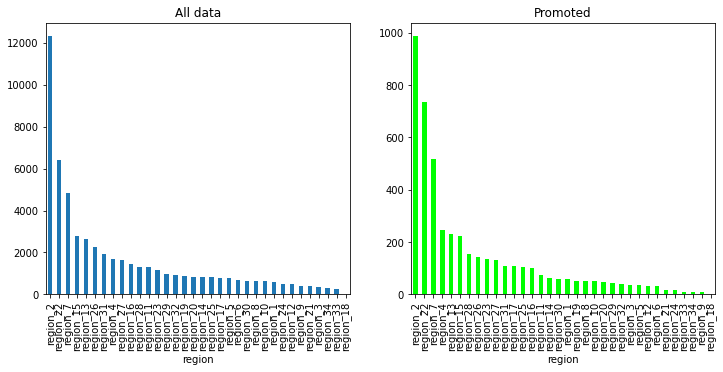

----------------------------------------------------------------------------------------------------


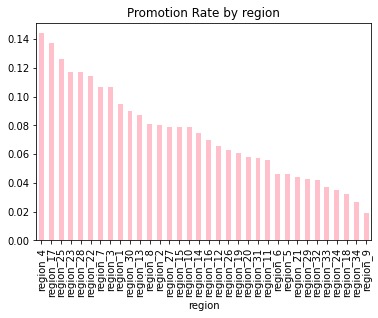

--------------------------------------------------
+-----------+----------------+
|   region  | Promotion Rate |
+-----------+----------------+
|  region_4 |     0.144      |
| region_17 |     0.137      |
| region_25 |     0.126      |
| region_23 |     0.117      |
| region_28 |     0.117      |
| region_22 |     0.114      |
|  region_7 |     0.107      |
|  region_3 |     0.107      |
|  region_1 |     0.095      |
| region_30 |      0.09      |
| region_13 |     0.087      |
|  region_8 |     0.081      |
|  region_2 |      0.08      |
| region_27 |     0.079      |
| region_15 |     0.079      |
| region_10 |     0.079      |
| region_14 |     0.075      |
| region_16 |      0.07      |
| region_12 |     0.066      |
| region_26 |     0.063      |
| region_19 |     0.061      |
| region_20 |     0.058      |
| region_31 |     0.057      |
| region_11 |     0.056      |
|  region_6 |     0.046      |
|  region_5 |     0.046      |
| region_21 |     0.044      |
| region_29 |     0

In [ ]:
EDA_categorical('region')

In [ ]:
# Regions with observations < 1%
print('Following regions have < 1% observations')
print('-'*50)
train_data.region.value_counts(dropna=False)[(train_data.region.value_counts(dropna=False)/train_data.shape[0])*100 < 1]

Following regions have < 1% observations
--------------------------------------------------


region_24    508
region_12    500
region_9     420
region_21    411
region_3     346
region_34    292
region_33    269
region_18     31
Name: region, dtype: int64

### Observation

- High cardinality ($34$)
- Difference in categorical frequency distribution and Promotion rate by category.
- region_24, region_12, region_9, region_21, region_3, region_34, region_33 and region_18  have less than $1\%$ observations. We will impute them with `rare_region` keyword. 

## `education`

has Missing values.

There are 4 unique categories in education: ["Master's & above" "Bachelor's" nan 'Below Secondary'].
--------------------------------------------------


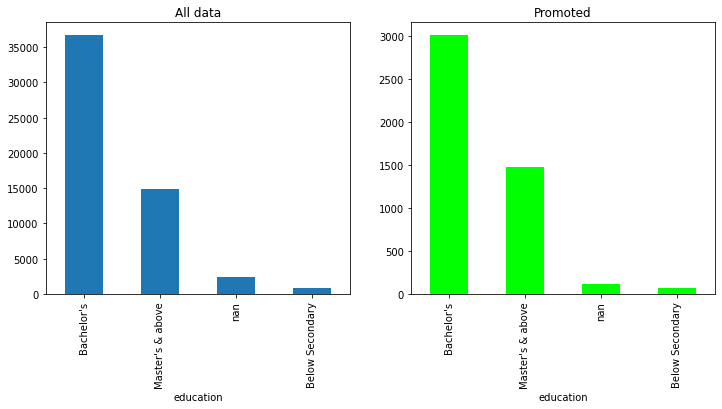

----------------------------------------------------------------------------------------------------


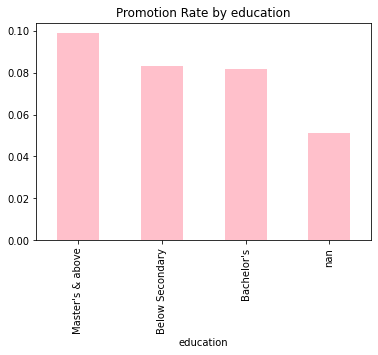

--------------------------------------------------
+------------------+----------------+
|    education     | Promotion Rate |
+------------------+----------------+
| Master's & above |     0.099      |
| Below Secondary  |     0.083      |
|    Bachelor's    |     0.082      |
|       nan        |     0.051      |
+------------------+----------------+


In [ ]:
EDA_categorical('education')

### Exploring Missing Values

In [ ]:
train_data[train_data.education.isna()].head(n=20)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
10,29934,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
21,33332,Operations,region_15,NaN,m,sourcing,1,41,4.0,11,0,0,57,0
32,35465,Sales & Marketing,region_7,NaN,f,sourcing,1,24,1.0,2,0,0,48,0
43,17423,Sales & Marketing,region_2,NaN,m,other,3,24,2.0,2,0,0,48,0
82,66013,Sales & Marketing,region_2,NaN,m,sourcing,2,25,3.0,2,0,0,53,0
87,69094,Sales & Marketing,region_2,NaN,m,sourcing,1,39,1.0,9,0,0,49,0
90,62658,Sales & Marketing,region_2,NaN,f,sourcing,1,20,NaN,1,0,0,55,0
189,6254,Operations,region_2,NaN,f,other,1,33,4.0,9,0,0,64,0
204,60761,Operations,region_16,NaN,f,other,1,31,4.0,2,0,0,62,0
231,57235,Sales & Marketing,region_26,NaN,m,other,1,22,4.0,2,0,0,51,0


- 

In [ ]:
#education_na.groupby(by='education')['avg_training_score'].mean()

# 'KPIs_met >80%', 'awards_won?'

sub_data = train_data.loc[:,['education', 'no_of_trainings', 'age', 'length_of_service', 'KPIs_met >80%', 'awards_won?','avg_training_score']]#.copy()

sub_data.education = sub_data.education.astype(str)

print('-------------- Number of Trainings ------------')
print(sub_data.groupby(by='education')['no_of_trainings'].aggregate(['mean', 'median']))
print()

print('-------------- Age ------------')
print(sub_data.groupby(by='education')['age'].aggregate(['mean', 'median']))
print()

print('-------------- Length of Service ------------')
print(sub_data.groupby(by='education')['length_of_service'].aggregate(['mean', 'median']))
print()

print('-------------- Average Training Score ------------')
print(sub_data.groupby(by='education')['avg_training_score'].aggregate(['mean', 'median']))
print()

print('-------------- KPIs_met >80% ------------')
print(sub_data.groupby(by='education')['KPIs_met >80%'].value_counts()[:,1] / sub_data.groupby(by='education')['KPIs_met >80%'].count())
print()

print('-------------- awards_won? ------------')
print(sub_data.groupby(by='education')['awards_won?'].value_counts()[:,1] / sub_data.groupby(by='education')['awards_won?'].count())


-------------- Number of Trainings ------------
                      mean  median
education                         
Bachelor's        1.270883       1
Below Secondary   1.275776       1
Master's & above  1.219095       1
nan               1.183479       1

-------------- Age ------------
                       mean  median
education                          
Bachelor's        33.445226      32
Below Secondary   23.836025      24
Master's & above  39.352630      38
nan               30.968867      29

-------------- Length of Service ------------
                      mean  median
education                         
Bachelor's        5.344542       4
Below Secondary   1.704348       2
Master's & above  7.605293       7
nan               4.407223       3

-------------- Average Training Score ------------
                       mean  median
education                          
Bachelor's        63.422046      60
Below Secondary   64.925466      62
Master's & above  64.061240      61
nan 

### Observation

- *Masters degree* holders have best promotion rate.
- Low Cardinality (4) including missing values as seperate category.
- Less percentage of people promoted ($\approx5\%$) for missing data compared to available data ($\approx 9\%$).
- NA has distinct characteristics across Variables. Thus, NA will be a seperate category and will be imputed with the `missing` word.



## `gender`

There are 2 unique categories in gender: ['f' 'm'].
--------------------------------------------------


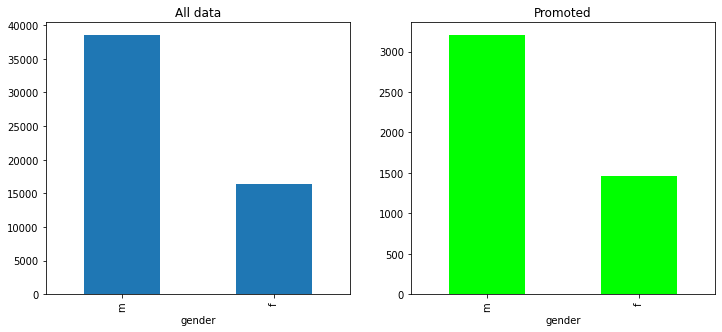

----------------------------------------------------------------------------------------------------


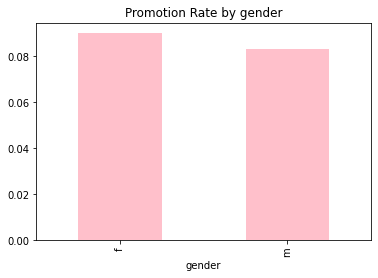

--------------------------------------------------
+--------+----------------+
| gender | Promotion Rate |
+--------+----------------+
|   f    |      0.09      |
|   m    |     0.083      |
+--------+----------------+


In [ ]:
EDA_categorical('gender')

### Observation
- Frequency of promoted employees follows natural frequency distribution of the dataset.
- Promotion rate is slightly higher for Female employees compared to Male employees. However this may be because of difference in frequency.
- No apparent Gender Bias.

In [ ]:
# CHi - square test
# table, results, exp_freq = rp.crosstab(train_data.gender, train_data.is_promoted, prop = 'col', test= 'chi-square', expected_freqs=True)
# exp_freq
# results

## `recruitment_channel`

There are 3 unique categories in recruitment_channel: ['sourcing' 'other' 'referred'].
--------------------------------------------------


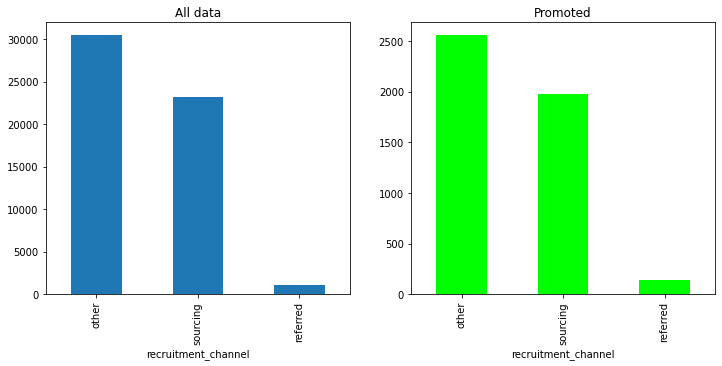

----------------------------------------------------------------------------------------------------


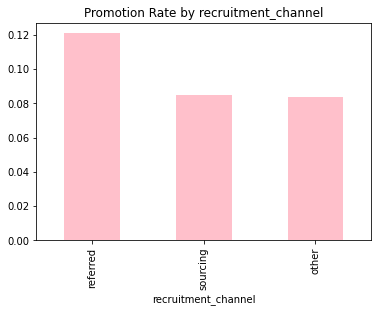

--------------------------------------------------
+---------------------+----------------+
| recruitment_channel | Promotion Rate |
+---------------------+----------------+
|       referred      |     0.121      |
|       sourcing      |     0.085      |
|        other        |     0.084      |
+---------------------+----------------+


In [ ]:
EDA_categorical('recruitment_channel')

### Observation
- Natural frequency distribution and promotion rate are opposite of each other.
- `reffered` candidate has the highest rate of promotion and is considerably higher compared to other two categories. `sourcing` and `other` categories have similar rate of promotion compared to each other.

## `KPIs_met >80%`

There are 2 unique categories in KPIs_met >80%: [1 0].
--------------------------------------------------


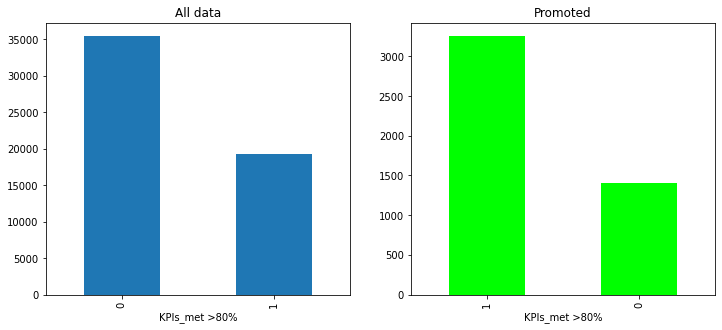

----------------------------------------------------------------------------------------------------


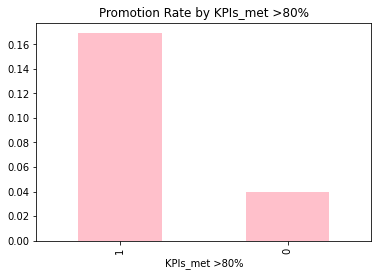

--------------------------------------------------
+---------------+----------------+
| KPIs_met >80% | Promotion Rate |
+---------------+----------------+
|       1       |     0.169      |
|       0       |      0.04      |
+---------------+----------------+


In [ ]:
EDA_categorical('KPIs_met >80%')

### Observation

- As expected employees who have met $> 80\%$ KPI's have much higher rate of being promoted ($\approx 4$ times) compared to those who have not. 